In [52]:
!pip install evaluate
!pip install rouge_score
!pip install transformers
!pip install nltk
!pip install spacy
!pip install sumy
!python -m spacy download en_core_web_sm
!pip install wordcloud



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [53]:
import pandas as pd
import re
import nltk
import spacy
from transformers import BartTokenizer, BartForConditionalGeneration
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import evaluate
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [54]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [56]:
df.isnull().sum()

,0
Unnamed: 0,0
description,0
medical_specialty,0
sample_name,0
transcription,33
keywords,1068


In [57]:
#SpaCy model
nlp = spacy.load('en_core_web_sm')

nltk.download('punkt_tab')

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

# Preprocess function
def preprocess_text(text):
    cleaned = clean_text(text)
    doc = nlp(cleaned)
    sentences = [sent.text.strip() for sent in doc.sents]
    return " ".join(sentences)

# Applying preprocessing
df['cleaned_transcription'] = df['transcription'].apply(preprocess_text)

df = df[df['cleaned_transcription'].str.strip() != ""]
df.reset_index(drop=True, inplace=True)

print("Dataset cleaned! Rows after cleaning:", len(df))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dataset cleaned! Rows after cleaning: 4966


In [58]:
def textrank_summary(text, num_sentences=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    summarized_text = " ".join(str(sentence) for sentence in summary)
    return summarized_text


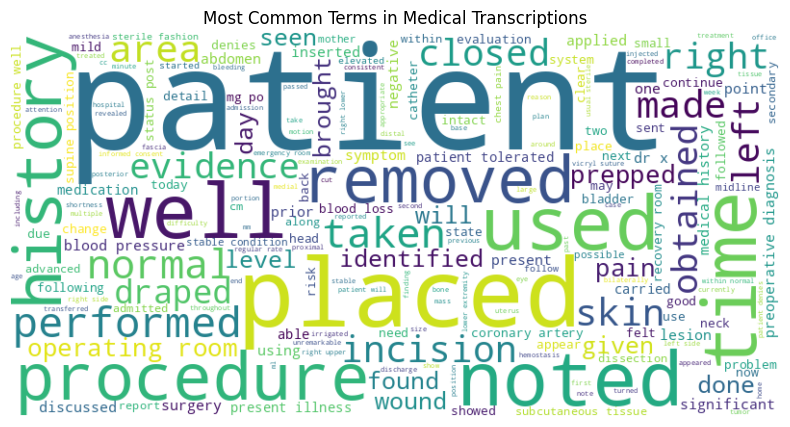

In [59]:
text = " ".join(str(x) for x in df['cleaned_transcription'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Terms in Medical Transcriptions')
plt.show()



In [60]:
# Loading BART model
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

def bart_summary(text):
    inputs = bart_tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    summary_ids = bart_model.generate(inputs['input_ids'], num_beams=4, max_length=150, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [61]:
def classify_summary(summary):
    summary = summary.lower()
    urgent_keywords = ['severe', 'emergency', 'chest pain', 'shortness of breath', 'stroke']
    doctor_visit_keywords = ['persistent', 'consult', 'examination', 'checkup', 'follow-up']
    home_care_keywords = ['mild', 'rest', 'monitor', 'flu', 'cold', 'headache']

    if any(word in summary for word in urgent_keywords):
        return "Urgent Care Alert: Please seek immediate medical attention."
    elif any(word in summary for word in doctor_visit_keywords):
        return "Consultation Recommendation: Please schedule a consultation with a healthcare professional."
    elif any(word in summary for word in home_care_keywords):
        return "Home Monitoring: Symptoms can be monitored at home. Maintain rest and hydration."
    else:
        return "Consultation Recommendation: Please consult a healthcare provider for evaluation."


In [62]:


# Loading ROUGE for evaluation
rouge = evaluate.load('rouge')

def evaluate_summarization(reference_text, generated_summary):
    results = rouge.compute(predictions=[generated_summary], references=[reference_text])
    return results

In [63]:
def healthbot_pipeline(transcription):
    print("\n--- Preprocessing ---")
    clean_text = preprocess_text(transcription)

    print("\n--- Extractive Summarization (TextRank) ---")
    extractive_summary = textrank_summary(clean_text)
    print("Extractive Summary:\n", extractive_summary)

    print("\n--- Abstractive Summarization (BART) ---")
    final_summary = bart_summary(extractive_summary)
    print("Final Summary:\n", final_summary)

    print("\n--- Chatbot Recommendation ---")
    recommendation = classify_summary(final_summary)
    print(recommendation)

    print("\n--- Summarization Evaluation Metrics (ROUGE) ---")
    metrics = evaluate_summarization(clean_text, final_summary)
    print(metrics)



In [64]:
# Going with example data from 10th row in dataset
sample_text = df['transcription'][10]
healthbot_pipeline(sample_text)



--- Preprocessing ---

--- Extractive Summarization (TextRank) ---
Extractive Summary:
 preoperative diagnosis  morbid obesity postoperative diagnosis  morbid obesity procedure laparoscopic rouxeny gastric bypass antecolic antegastric with 25mm eea anastamosis esophagogastroduodenoscopy anesthesia  general with endotracheal intubation indications for procedure  this is a 50yearold male who has been overweight for many years and has tried multiple different weight loss diets and programs the patient has now begun to have comorbidities related to the obesity the patient has attended our bariatric seminar and met with our dietician and psychologist the patient has read through our comprehensive handout and understands the risks and benefits of bypass surgery as evidenced by the signing of our consent formprocedure in detail  the risks and benefits were explained to the patient consent was obtained the patient was taken to the operating room and placed supine on the operating room table g